In [1]:
import pandas as pd
import numpy as np
from itertools import product

from tqdm import tqdm 

import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.arima.model import ARIMA

from utils import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
data = pd.read_csv('vodafone_data.csv')

In [3]:
data.head()

,Date,Open,High,Low,Close,Volume
0,2016-02-11,29.330000,29.510000,29.030001,29.270000,4805000
1,2016-02-12,29.520000,29.950001,29.410000,29.900000,3116500
2,2016-02-16,29.950001,30.420000,29.900000,30.260000,4037900
3,2016-02-17,31.000000,31.320000,30.900000,31.090000,4313800
4,2016-02-18,31.090000,31.150000,30.920000,30.959999,3522800


## Підготовка даних

In [4]:
def dataset_preprocess(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date_index'] = pd.DatetimeIndex(df['Date']) 
    
    data_no_missing = df.copy(deep=True)

    data_no_missing = data_no_missing.set_index('Date_index').asfreq('D')

    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        data_no_missing[col] = data_no_missing[col].interpolate()

    data_no_missing = data_no_missing.reset_index(drop=False)

    data_no_missing['Date'] = pd.to_datetime(data_no_missing['Date_index']).dt.date
    data_no_missing['year'] = pd.to_datetime(data_no_missing['Date']).dt.year
    data_no_missing['quarter'] = pd.to_datetime(data_no_missing['Date']).dt.quarter
    data_no_missing['month'] = pd.to_datetime(data_no_missing['Date']).dt.month
    
    return df, data_no_missing

In [5]:
df, data_no_missing = dataset_preprocess(data)

### Перевірка на стаціонарність

#### Тест Дікі-Фулера

In [6]:
stationarity_test(data_no_missing.Close, smt.adfuller)

{'adfuller_statistics': -1.2810249204236712,
 'adfuller_p_value': 0.6378081111339106,
 'adfuller_critical_values': {'1%': -3.4339382310452033,
  '5%': -2.863125003847544,
  '10%': -2.56761380228936}}

#### KPSS тест

In [7]:
stationarity_test(data_no_missing.Close, smt.kpss)

{'kpss_statistics': 5.98948825089506,
 'kpss_p_value': 0.01,
 'kpss_critical_values': {'10%': 0.347,
  '5%': 0.463,
  '2.5%': 0.574,
  '1%': 0.739}}

#### Бачимо, що вихідний часовий ряд не є стаціонарним

## Побудова моделей за допомогою крос-валідації для різних наборів порядків

In [8]:
data_no_missing = data_no_missing.reset_index(drop=False)

In [9]:
data_no_missing.head(2)

,index,Date_index,Date,Open,High,Low,Close,Volume,year,quarter,month
0,0,2016-02-11,2016-02-11,29.33,29.510000,29.030001,29.27,4805000.0,2016,1,2
1,1,2016-02-12,2016-02-12,29.52,29.950001,29.410000,29.90,3116500.0,2016,1,2


In [10]:
D_ORDERS_RANGE = range(5)
P_ORDERS_RANGE = [8] * len(D_ORDERS_RANGE)
Q_ORDERS_RANGE = [9] * len(D_ORDERS_RANGE)

In [11]:
N_SPLITS = 7

In [12]:
INDEX = pd.MultiIndex.from_product((P_ORDERS_RANGE, D_ORDERS_RANGE, Q_ORDERS_RANGE, list(range(N_SPLITS))))
INDEX = pd.MultiIndex.from_tuples(list(set(INDEX)), names=['P', 'D', 'Q', 'Fold Number'])

In [13]:
def make_cross_validation(df, target_column='Close', n_splits=5, test_size=30, arima_order=(1, 1, 1),
                          lags=12,
                          folds_plots_size=(10, 30), stat_plot_size=(10, 8), plot=False
                          ):
    ts = df[target_column]

    folds_indexes = list(TimeSeriesSplit(n_splits=n_splits, test_size=test_size).split(ts))
    min_fold_len = min([len(fold[0]) for fold in folds_indexes])

    for i in range(len(folds_indexes)):
        folds_indexes[i] = (folds_indexes[i][0][-min_fold_len:], folds_indexes[i][1])

    if plot:
        plot_data_by_fold(df, folds_indexes, folds_plots_size)

    all_metrics_df_arima = pd.DataFrame()
    all_metrics_df_test_arima = pd.DataFrame()

    for fold_index, fold in enumerate(folds_indexes):
        train_indexes = fold[0]
        test_indexes = fold[1]

        train_df_tmp = df.loc[train_indexes, :]
        test_df_tmp = df.loc[test_indexes, :]

        if plot:
            plt.figure(figsize=(10, 8))
            train_df_tmp.plot(title='Train process', figsize=stat_plot_size);
            plt.show()

            plt.figure(figsize=(10, 8))
            test_df_tmp.plot(title='Test process', figsize=stat_plot_size);
            plt.show()

            plt.figure(figsize=(10, 8))
            plot_pacf_acf(train_df_tmp, lags=lags)
            plt.show()

        arima_model = ARIMA(train_df_tmp[target_column], order=arima_order)
        arima_model_fitted = arima_model.fit()

        arima_predictions = pd.Series(arima_model_fitted.predict())
        test_arima_predictions = pd.Series(arima_model_fitted.forecast(steps=test_df_tmp.shape[0]).values,
                                           copy=True)

        metrics_df_arima, metrics_df_test_arima = calc_all_metrics(train_df_tmp, test_df_tmp, arima_predictions,
                                                                   test_arima_predictions, arima_model_fitted
                                                                  )
        
        metrics_df_arima.index = pd.Series(str((arima_order[0], arima_order[1],
                                                arima_order[2], fold_index)))
        
        metrics_df_test_arima.index = pd.Series(str((arima_order[0], arima_order[1], 
                                                     arima_order[2], fold_index)))

        all_metrics_df_arima = pd.concat((all_metrics_df_arima, metrics_df_arima), axis=0)
        all_metrics_df_test_arima = pd.concat((all_metrics_df_test_arima, metrics_df_test_arima), axis=0)

        if plot:
            plt.figure(figsize=(10, 8))
            plot_results(train_df_tmp[target_column], arima_predictions)
            plt.show()

            plt.figure(figsize=(10, 8))
            plot_results(test_df_tmp[target_column], test_arima_predictions)
            plt.show()

    return all_metrics_df_arima, all_metrics_df_test_arima

In [14]:
def get_cross_val_results(data, n_splits, test_size, lags, p_orders_range=P_ORDERS_RANGE,
                          d_orders_range = D_ORDERS_RANGE, q_orders_range=Q_ORDERS_RANGE,
                          plot=False):
    
    all_metrics_df_arima = pd.DataFrame()
    all_metrics_df_test_arima = pd.DataFrame()
    
    for p, d, q in zip(p_orders_range, d_orders_range, q_orders_range):
        
        metrics_df_arima, metrics_df_test_arima = make_cross_validation(
            data, n_splits=n_splits, test_size=test_size, lags=lags, arima_order=(p, d, q),
            plot=plot)
        
        all_metrics_df_arima = pd.concat((all_metrics_df_arima, metrics_df_arima))
        all_metrics_df_test_arima = pd.concat((all_metrics_df_test_arima, metrics_df_test_arima))
        
    return all_metrics_df_arima, all_metrics_df_test_arima

In [15]:
all_metrics_df_arima, all_metrics_df_test_arima = get_cross_val_results(data_no_missing, N_SPLITS, 100, 30)

In [16]:
all_metrics_df_arima.head()

,RMSE,RSS,MSE,MAE,MAPE,R2,durbin_watson,aic,bic
"(8, 0, 9, 0)",0.283959,90.953895,0.080633,0.174744,0.006569,0.995383,1.908267,-2802.133341,-2706.597513
"(8, 0, 9, 1)",0.351093,139.044724,0.123267,0.172381,0.006825,0.994343,1.586280,-2323.361734,-2227.825907
"(8, 0, 9, 2)",0.313074,110.561097,0.098015,0.162450,0.006815,0.995711,1.670086,-2581.930195,-2486.394368
"(8, 0, 9, 3)",0.243871,67.085531,0.059473,0.153007,0.006650,0.997422,1.972540,-3145.478877,-3049.943050
"(8, 0, 9, 4)",0.285864,92.178438,0.081718,0.170689,0.008000,0.996987,1.872354,-2787.048020,-2691.512193


In [17]:
all_metrics_df_test_arima.head()

,RMSE,RSS,MSE,MAE,MAPE,R2,durbin_watson,aic,bic
"(8, 0, 9, 0)",2.187247,478.404784,4.784048,1.701400,NaN,-2.392891,1.908267,194.528702,244.026935
"(8, 0, 9, 1)",2.257831,509.779936,5.097799,1.870551,NaN,-1.736180,1.586280,200.880895,250.379128
"(8, 0, 9, 2)",0.826504,68.310929,0.683109,0.717055,NaN,-0.835020,1.670086,-0.110042,49.388191
"(8, 0, 9, 3)",3.948814,1559.312887,15.593129,2.876961,NaN,-0.824370,1.972540,312.683036,362.181270
"(8, 0, 9, 4)",1.968676,387.568328,3.875683,1.682754,NaN,-1.896298,1.872354,173.472198,222.970431


In [20]:
idx = all_metrics_df_arima.index.tolist()
idx = [tuple(list(map(int, el.replace('(', '').replace(')', '').split(', ')))) for el in idx]
idx = pd.MultiIndex.from_tuples(idx, names=['P', 'D', 'Q', 'Fold Number'])

all_metrics_df_arima.index = idx

In [21]:
all_metrics_df_arima.head()

RMSE         RSS       MSE       MAE      MAPE  \
P D Q Fold Number                                                       
8 0 9 0            0.283959   90.953895  0.080633  0.174744  0.006569   
      1            0.351093  139.044724  0.123267  0.172381  0.006825   
      2            0.313074  110.561097  0.098015  0.162450  0.006815   
      3            0.243871   67.085531  0.059473  0.153007  0.006650   
      4            0.285864   92.178438  0.081718  0.170689  0.008000   

                         R2  durbin_watson          aic          bic  
P D Q Fold Number                                                     
8 0 9 0            0.995383       1.908267 -2802.133341 -2706.597513  
      1            0.994343       1.586280 -2323.361734 -2227.825907  
      2            0.995711       1.670086 -2581.930195 -2486.394368  
      3            0.997422       1.972540 -3145.478877 -3049.943050  
      4            0.996987       1.872354 -2787.048020 -2691.512193

In [22]:
idx = all_metrics_df_test_arima.index.tolist()
idx = [tuple(list(map(int, el.replace('(', '').replace(')', '').split(', ')))) for el in idx]
idx = pd.MultiIndex.from_tuples(idx, names=['P', 'D', 'Q', 'Fold Number'])

all_metrics_df_test_arima.index = idx

In [23]:
all_metrics_df_test_arima.head()

RMSE          RSS        MSE       MAE  MAPE        R2  \
P D Q Fold Number                                                               
8 0 9 0            2.187247   478.404784   4.784048  1.701400   NaN -2.392891   
      1            2.257831   509.779936   5.097799  1.870551   NaN -1.736180   
      2            0.826504    68.310929   0.683109  0.717055   NaN -0.835020   
      3            3.948814  1559.312887  15.593129  2.876961   NaN -0.824370   
      4            1.968676   387.568328   3.875683  1.682754   NaN -1.896298   

                   durbin_watson         aic         bic  
P D Q Fold Number                                         
8 0 9 0                 1.908267  194.528702  244.026935  
      1                 1.586280  200.880895  250.379128  
      2                 1.670086   -0.110042   49.388191  
      3                 1.972540  312.683036  362.181270  
      4                 1.872354  173.472198  222.970431

all_metrics_df_arima.to_csv('all_metrics_df_arima.csv', index=True)
all_metrics_df_test_arima.to_csv('all_metrics_df_test_arima.csv', index=True)

### Розподіл метрик по порядкам моделей

#### Тренувальні вибірки

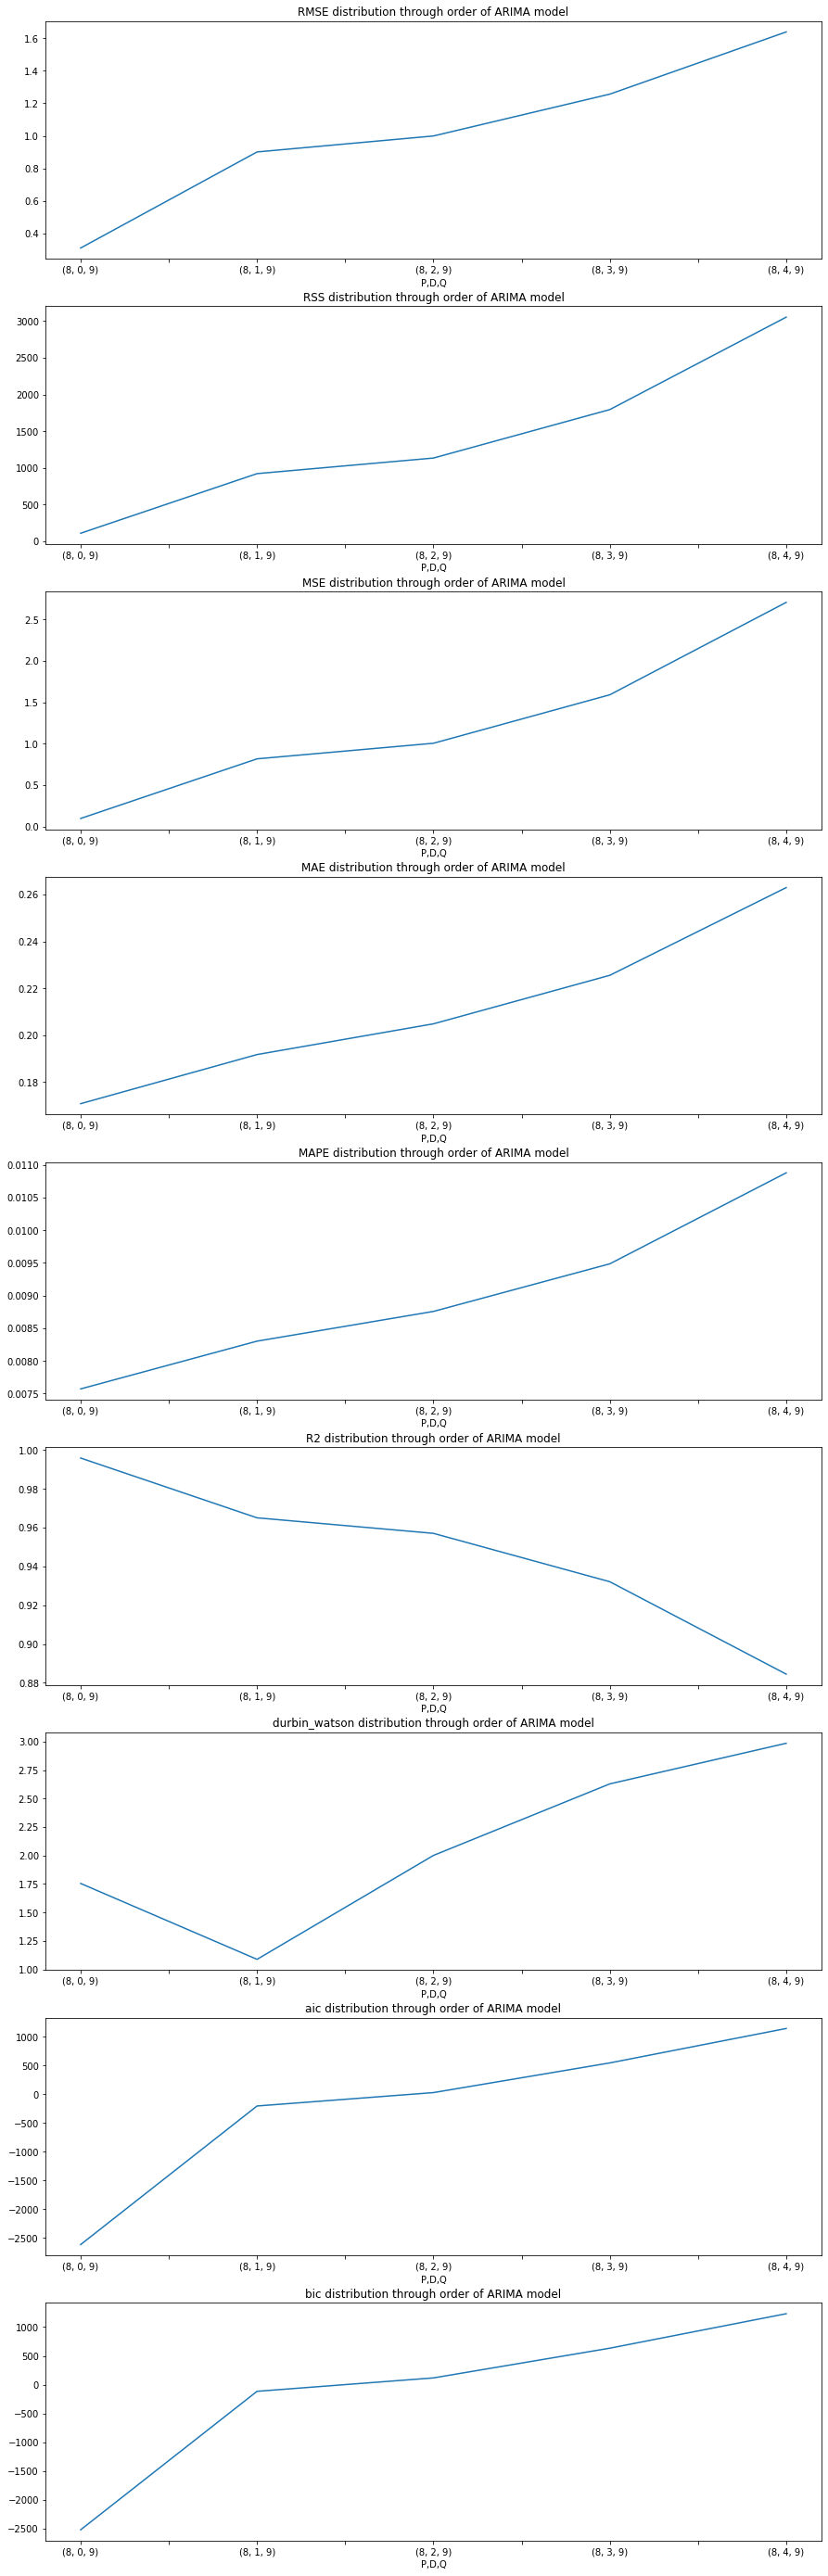

In [26]:
fig, axs = plt.subplots(nrows=all_metrics_df_arima.shape[1], ncols=1, figsize=(15, 50))

for idx, metric_title in enumerate(all_metrics_df_arima.columns):
    all_metrics_df_arima.reset_index().groupby(['P', 'D', 'Q'])[metric_title].mean().plot(
        title='{} distribution through order of ARIMA model'.format(metric_title), ax=axs[idx]);

#### Тестувальні вибірки

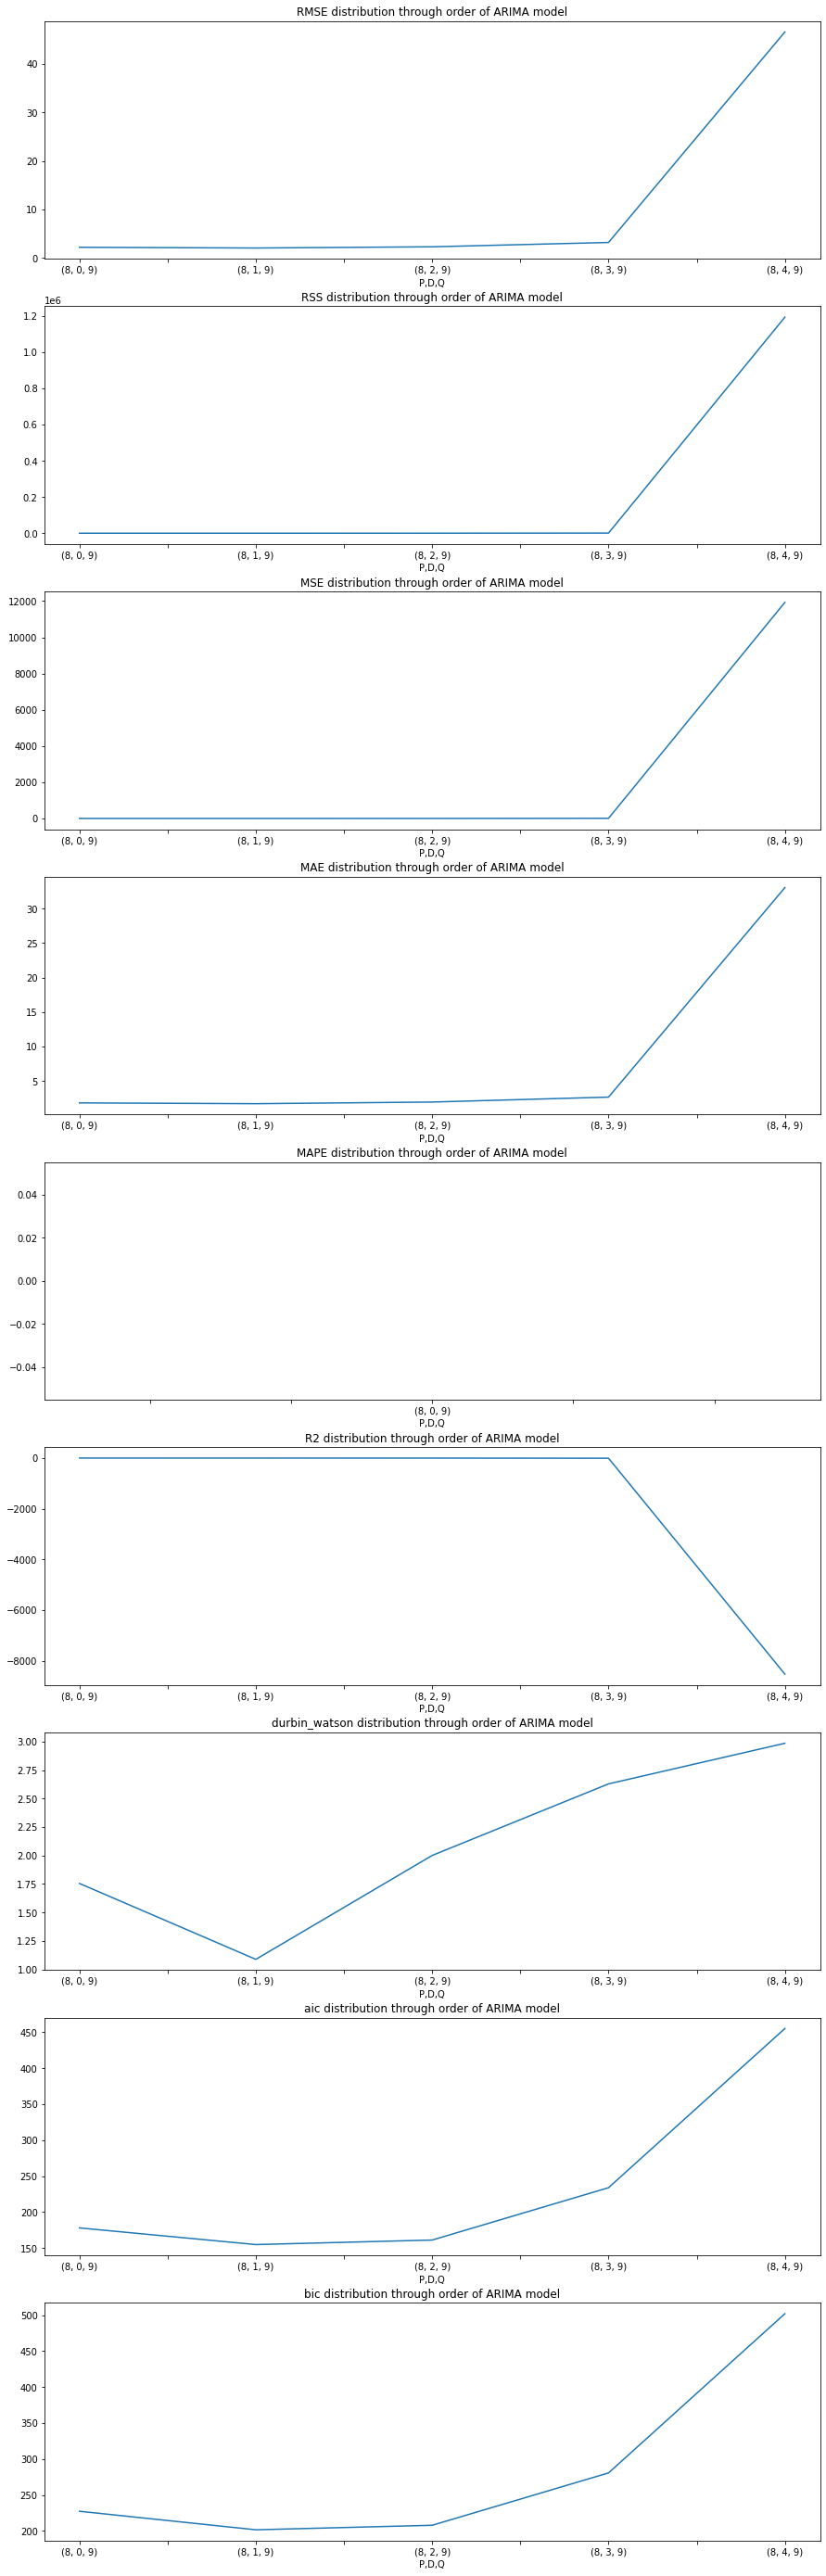

In [27]:
fig, axs = plt.subplots(nrows=all_metrics_df_test_arima.shape[1], ncols=1, figsize=(15, 50))

for idx, metric_title in enumerate(all_metrics_df_test_arima.columns):
    all_metrics_df_test_arima.reset_index().groupby(['P', 'D', 'Q'])[metric_title].mean().plot(
        title='{} distribution through order of ARIMA model'.format(metric_title), ax=axs[idx]);

## Метрики у вигляді таблиць

In [28]:
all_metrics_df_arima.shape, all_metrics_df_test_arima.shape

((35, 9), (35, 9))

In [29]:
all_metrics_df_arima.head(3)

RMSE         RSS       MSE       MAE      MAPE  \
P D Q Fold Number                                                       
8 0 9 0            0.283959   90.953895  0.080633  0.174744  0.006569   
      1            0.351093  139.044724  0.123267  0.172381  0.006825   
      2            0.313074  110.561097  0.098015  0.162450  0.006815   

                         R2  durbin_watson          aic          bic  
P D Q Fold Number                                                     
8 0 9 0            0.995383       1.908267 -2802.133341 -2706.597513  
      1            0.994343       1.586280 -2323.361734 -2227.825907  
      2            0.995711       1.670086 -2581.930195 -2486.394368

In [30]:
all_metrics_df_test_arima.head(3)

RMSE         RSS       MSE       MAE  MAPE        R2  \
P D Q Fold Number                                                             
8 0 9 0            2.187247  478.404784  4.784048  1.701400   NaN -2.392891   
      1            2.257831  509.779936  5.097799  1.870551   NaN -1.736180   
      2            0.826504   68.310929  0.683109  0.717055   NaN -0.835020   

                   durbin_watson         aic         bic  
P D Q Fold Number                                         
8 0 9 0                 1.908267  194.528702  244.026935  
      1                 1.586280  200.880895  250.379128  
      2                 1.670086   -0.110042   49.388191

#### усереднюємо метрики по фолдам для кожного набору порядків моделі

In [35]:
all_train_metrics_resampled_arima = all_metrics_df_arima.reset_index().groupby(
    ['P', 'D', 'Q']).mean().drop('Fold Number', axis=1)

all_test_metrics_resampled_arima = all_metrics_df_test_arima.reset_index().groupby(
    ['P', 'D', 'Q']).mean().drop('Fold Number', axis=1)

In [36]:
pd.set_option('display.max.rows', None)

In [38]:
all_train_metrics_resampled_arima

RMSE          RSS       MSE       MAE      MAPE        R2  \
P D Q                                                                  
8 0 9  0.310910   110.736774  0.098171  0.170737  0.007572  0.995914   
  1 9  0.901295   922.631550  0.817936  0.191705  0.008303  0.965094   
  2 9  0.999449  1134.962053  1.006172  0.204821  0.008758  0.957089   
  3 9  1.256659  1795.077027  1.591380  0.225529  0.009487  0.932143   
  4 9  1.638848  3053.882583  2.707343  0.262967  0.010879  0.884501   

       durbin_watson          aic          bic  
P D Q                                           
8 0 9       1.754303 -2615.940336 -2520.404509  
  1 9       1.088108  -206.236627  -115.729001  
  2 9       2.000283    26.552492   117.060118  
  3 9       2.628539   542.727534   633.235160  
  4 9       2.985092  1141.445088  1231.952714

In [39]:
all_test_metrics_resampled_arima

RMSE           RSS           MSE        MAE  MAPE           R2  \
P D Q                                                                        
8 0 9   2.222339  5.810267e+02      5.810267   1.836146   NaN    -2.646698   
  1 9   2.070349  5.257096e+02      5.257096   1.721310   NaN    -2.376983   
  2 9   2.320664  7.063599e+02      7.063599   1.958824   NaN    -3.846029   
  3 9   3.211991  1.377221e+03     13.772210   2.673654   NaN   -10.097368   
  4 9  46.540286  1.192678e+06  11926.779142  33.048325   NaN -8522.682985   

       durbin_watson         aic         bic  
P D Q                                         
8 0 9       1.754303  177.901188  227.399421  
  1 9       1.088108  154.747859  201.640922  
  2 9       2.000283  161.034669  207.927733  
  3 9       2.628539  233.819918  280.712981  
  4 9       2.985092  455.235019  502.128083